In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

from Function.Stimulation_GPU import *
from Function.ReceptiveField_GPU import *
from Function.plot_SNN import *
from Function.SNN_230327 import SNNModel
from Function.SNNModule import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
print("GPU available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

GPU available: True
CUDA version: 10.1


In [14]:
# # on mac
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
# print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
# print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
# !python -c 'import platform;print(platform.platform())'

In [15]:
sensor_h, sensor_w = 19, 16 #(mm)
pixel_h, pixel_w = 64, 48 # (#)
img_FPS = 60

In [19]:
SA_rf,[SA_top_h,SA_top_v] = generate_mechanoreceptor_to_afferent_rf(step_size = 3)
RA_rf,[RA_top_h,RA_top_v] = generate_mechanoreceptor_to_afferent_rf(kernel_w=15, kernel_h=15)

print(SA_rf.shape)
print(SA_top_h,SA_top_v)
# receptive_field_optimized = [torch.tensor([[3, -1], [3, -1], [3, -1], [3, -1], [3, -1]], device=device),
#                              torch.tensor(
#                                  [[3, 3, 3, 3, 3], [-1, -1, -1, -1, -1]], device=device),
#                              10 * torch.ones((7, 7), device=device)
#                             ]

# receptive_field_optimized = [torch.tensor([[0.5, 1, 0.5], [1, 2, 1], [0.5, 1, 0.5]], device=device)*3]

# receptive_field_optimized = [torch.tensor([[8, -4], [8, -4], [8, -4], [8, -4], [8, -4]], device=device),
#                              torch.tensor(
#                                  [[8, 8, 8, 8, 8], [-4, -4, -4, -4, -4]], device=device),
#                              12 * torch.ones((7, 7), device=device),
#                              torch.tensor([[0.5, 1, 0.5], [1, 2, 1], [
#                                           0.5, 1, 0.5]], device=device)*3,
#                              torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], device=device)*10,  # Sobel horizontal
#                              torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=device)*10,  # Sobel vertical
#                              torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*10,  # Prewitt horizontal
#                              torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*10,  # Prewitt vertical
# 

receptive_field_optimized = [
                            #  torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], device=device)*5,  # Sobel horizontal
                            #  torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=device)*5,  # Sobel vertical
                             torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*5,  # Prewitt horizontal
                             torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*5,  # Prewitt vertical
                            #  torch.tensor([[0, 0, -1], [0, 1, 0], [0, 0, 0]], device=device)*5, # Roberts horizontal
                            #  torch.tensor([[-1, 0, 0], [0, 1, 0], [0, 0, 0]], device=device)*5, # Roberts vertical
                            #  torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], device=device)*5, # Laplacian mask 1
                            #  torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], device=device)*5,
                            #  torch.tensor([[-1, 1], [-1, 1], [-1, 1]], device=device)*5,
                            #  torch.tensor([[-1,-1,-1],[1,1,1]], device =device)*5
]

receptive_field_optimized = [

    torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
                 device=device)*5,  # Prewitt vertical
    torch.tensor([[1, 1, 1], [0, 0, 0], [-1,-1, -1]],
                 device=device)*5,  # Prewitt horizontal

]
synaptic_delays_top = [
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
]

SA_rf_top, SA_rf_length = generate_afferent_to_top_rf(receptive_field_optimized, pixel_h=SA_top_v,
                                                                            pixel_w=SA_top_h, step_size=1, device = device)

RA_rf_top, RA_rf_length = generate_afferent_to_top_rf(receptive_field_optimized, pixel_h=RA_top_v,
                                                      pixel_w=RA_top_h, step_size=1, device=device)

SA_rf_top_delay, SA_rf_top_delay_length = generate_afferent_to_top_rf(synaptic_delays_top, pixel_h=SA_top_v,
                                                                      pixel_w=SA_top_h, step_size=1, device=device)

RA_rf_top_delay, RA_rf_top_delay_length = generate_afferent_to_top_rf(synaptic_delays_top, pixel_h=RA_top_v,
                                                                      pixel_w=RA_top_h, step_size=1, device=device)

print(SA_rf_length)
print(RA_rf_length)
print(SA_rf_top.device)
print(SA_rf_top)

Complete! Generated 247 receptive fields from mechanoreceptor to afferents with kernel size 10x10.
Complete! Generated 54 receptive fields from mechanoreceptor to afferents with kernel size 15x15.
torch.Size([247, 3072])
13 19
Complete! Generated 374 receptive fields from afferents to the top with kernel size 3x3. with step size 16x10
Complete! Generated 56 receptive fields from afferents to the top with kernel size 3x3. with step size 6x3
Complete! Generated 374 receptive fields from afferents to the top with kernel size 3x3. with step size 16x10
Complete! Generated 56 receptive fields from afferents to the top with kernel size 3x3. with step size 6x3
[187, 187]
[28, 28]
cuda:0
tensor([[-5.,  0.,  5.,  ...,  0.,  0.,  0.],
        [ 0., -5.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., -5.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., -5.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., -5., -5.,  0.],
        [ 0.,  0.,  0.,  ..., -5., -5., -5.]], device='cuda:0')


In [20]:
# Create Izhikevich layers
SA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_rf), a_decay=1 ,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 8, len(SA_rf_top), a_decay=1,device=device)
    ]

# Create synapses
SA_synapses = [
    Synapse(SA_rf.to(device),SA_rf_top_delay,device = device),
    Synapse(SA_rf_top.to(device),SA_rf_top_delay,device = device)
    ]

RA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_rf), a_decay=1,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_rf_top), a_decay=1,device=device)
    ]

RA_synapses =[
    Synapse(RA_rf.to(device),RA_rf_top_delay,device = device),
    Synapse(RA_rf_top.to(device), RA_rf_top_delay, device=device)
    ]
    


layers initialized
layers initialized
Synapses initialized
Synapses initialized
layers initialized
layers initialized
Synapses initialized
Synapses initialized


In [21]:
def run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device='cpu'):
    SA = SNNModel(SA_layers,SA_synapses,device)
    RA = SNNModel(RA_layers,RA_synapses,device)


    SA_stim = stim
    RA_stim = torch.abs(torch.diff(stim, dim = 2)) * 20

    SA_spike_times = SA.feedforward(SA_stim,plot_spikes=True)
    RA_spike_times = RA.feedforward(RA_stim)

    plt.plot(SA_stim[32,24,:].cpu().numpy())
    plt.plot(RA_stim[32, 24, :].cpu().numpy())

    plot_spike_times(SA.spike_times[0])
    print(SA.spike_times[0].shape)
    plt.imshow(torch.sum(SA.spike_times[0],axis=1).reshape(19,13),cmap='jet',vmin=0,vmax=500)
    plt.colorbar()
    plt.show()

    st_ind = 0
    for i in SA_rf_length:
        if i != 0:
            print(st_ind, st_ind+i)
            plot_spike_times(SA.spike_times[1][st_ind:st_ind + i],'b',size = (5,150/57))
            # plt.imshow(torch.sum(SA.spike_times[1][st_ind:st_ind + i], axis=1).reshape(8,5),cmap='jet',vmin=0,vmax=300)
            # plt.colorbar()
            # plt.show()
            st_ind = st_ind + i


    plot_spike_times(RA.spike_times[0])
    st_ind = 0
    for i in RA_rf_length:
        if i != 0:
            
            plot_spike_times(RA.spike_times[1][st_ind:st_ind + i],'g',size = (5,150/57))
            st_ind = st_ind + i

    return(SA,RA)

cuda:0


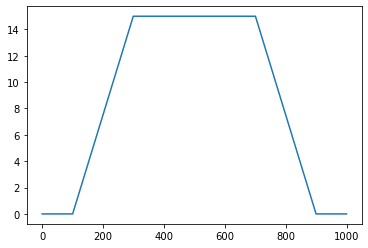

In [22]:
num_stim = 1000
stimulation_vertical = torch.zeros((pixel_h, pixel_w, num_stim),device = device)
max_F = 15
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])
for i, F_i in enumerate(F_array):
    stim_dot = elongated_stim(F=F_i*2, pixel_h=pixel_h,
                              pixel_w=pixel_w, orientation='vertical')
    # Use 'vertical' for vertically elongated stimulus
    # stim_dot = elongated_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w, orientation='vertical')
    stimulation_vertical[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_horizontal[:, :, i].cpu(),
    #                cmap='jet', vmin=0, vmax=max_F)
        
    #     plt.show()
print(stimulation_vertical.device)

plt.plot(F_array)
plt.show()

Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([

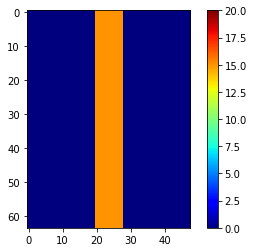

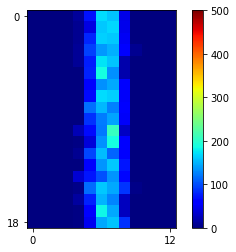

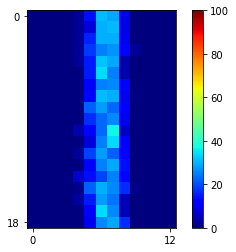

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

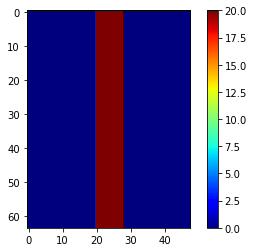

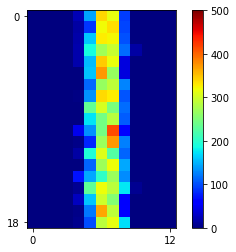

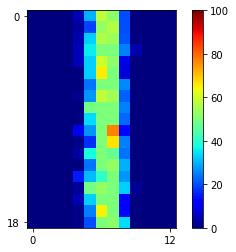

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

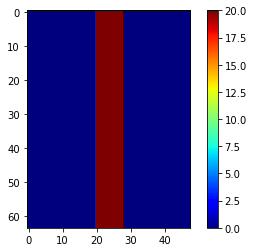

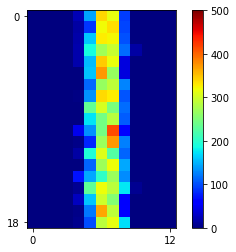

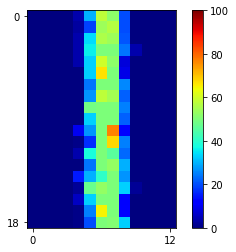

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

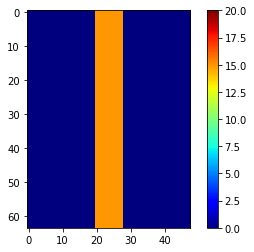

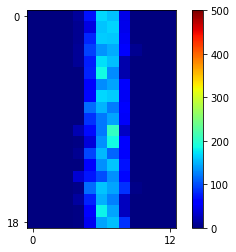

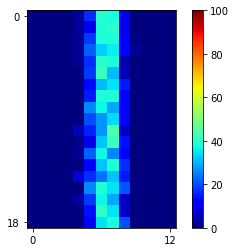

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

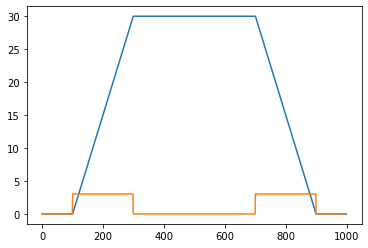

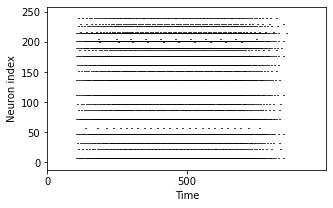

torch.Size([247, 999])


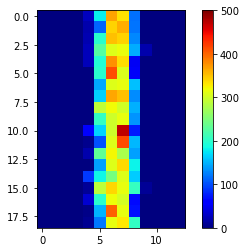

0 187


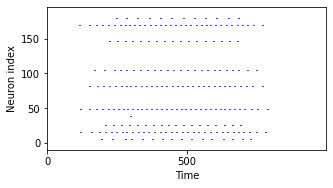

187 374


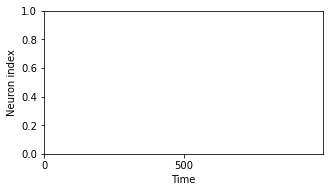

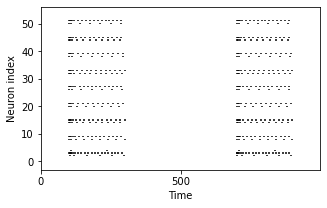

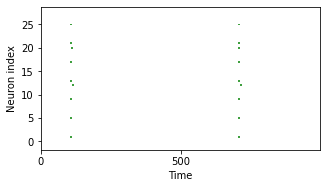

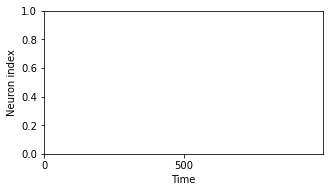

5.929811239242554


In [23]:
stim = stimulation_vertical
start_time = time.time()
[SA,RA]=run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
               SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)


cuda:0
torch.Size([64, 48])


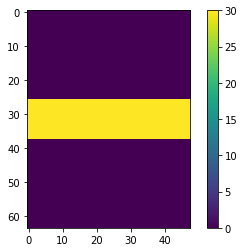

In [24]:
num_stim = 1000
stimulation_horizontal = torch.zeros((pixel_h, pixel_w, num_stim),device = device)
max_F = 15
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])
for i, F_i in enumerate(F_array):
    
    stim_dot = elongated_stim(F=F_i*2, pixel_h=pixel_h,
                              pixel_w=pixel_w, orientation='horizontal')
    # Use 'vertical' for vertically elongated stimulus
    # stim_dot = elongated_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w, orientation='vertical')
    stimulation_horizontal[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_horizontal[:, :, i].cpu(),
    #                cmap='jet', vmin=0, vmax=max_F)
        
    #     plt.show()
print(stimulation_horizontal.device)
print(stimulation_horizontal[:,:,500].shape)
plt.imshow(stimulation_horizontal[:,:,600].cpu().numpy())
plt.colorbar()
plt.show()

Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([

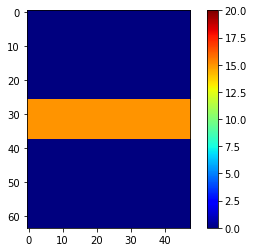

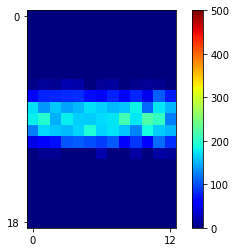

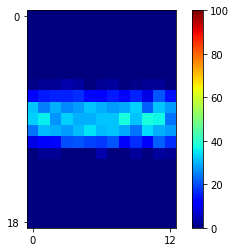

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

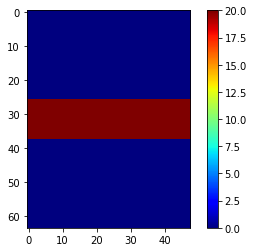

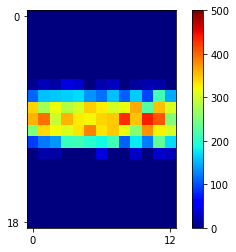

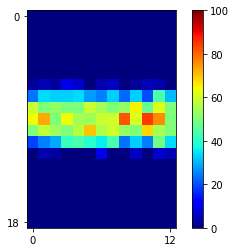

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

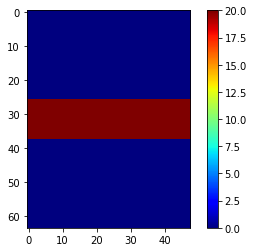

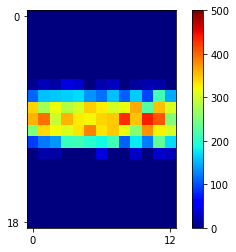

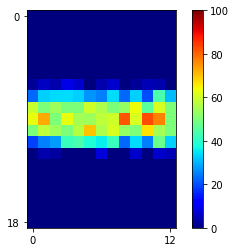

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

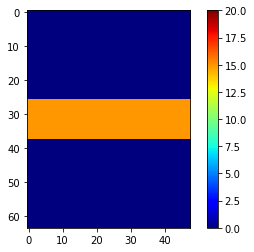

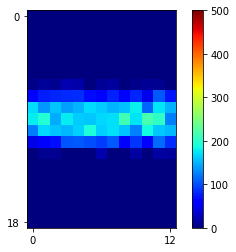

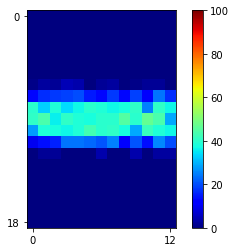

torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50, 247])
torch.Size([247])
torch.Size([374, 247])
torch.Size([50

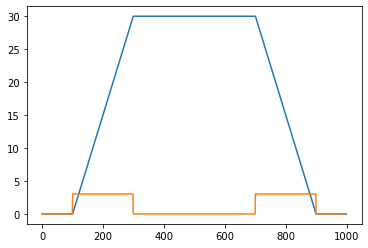

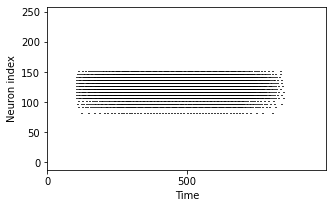

torch.Size([247, 999])


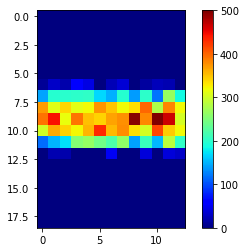

0 187


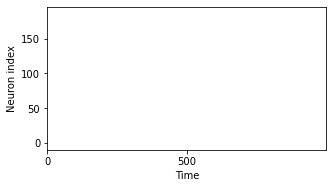

187 374


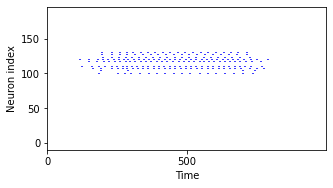

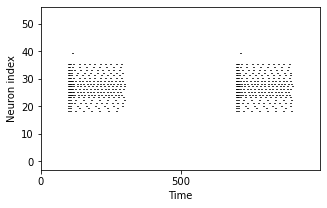

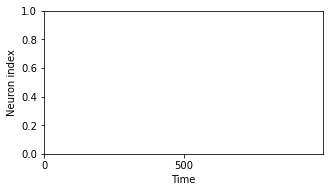

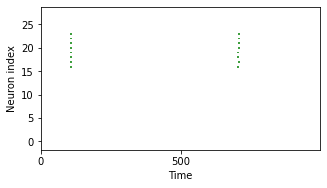

6.088060617446899


In [ ]:
stim = stimulation_horizontal
start_time = time.time()
[SA, RA] = run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
                          SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)
